<a href="https://colab.research.google.com/github/KangHwan-Cha/MyStudy/blob/main/TensorProject/Category5A__Sequence, Time Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Category 5

Sequence (시계열) 데이터 다루기

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

For this task you will need to train a neural network
to predict sunspot activity using the Sunspots.csv
provided. 

Your neural network is expected to have an MAE
of at least 20, with top marks going to one with an MAE
of around 15. 

At the bottom is provided some testing
code should you want to check before uploading which measures
the MAE for you. 

Strongly recommend you test your model with
this to be able to see how it performs.



-------------------------------
**Sequence(시퀀스)**

Sunspots.csv를 사용하여 **태양 흑점 활동(sunspot)**을 예측하는 인공신경망을 만듭니다.

MAE 오차 기준으로 최소 20이하로 예측할 것을 권장하며, 탑 랭킹에 들려면 MAE 15 근처에 도달해야합니다.

아래 주어진 샘플코드는 당신의 모델을 테스트 하는 용도로 활용할 수 있습니다.

-----------------------------------


## 필요한 모듈 import

In [53]:
import csv
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.layers import Dense, LSTM, Lambda, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

In [54]:
# sunspot: 태양의 흑점
url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
urllib.request.urlretrieve(url, 'sunspots.csv')

('sunspots.csv', <http.client.HTTPMessage at 0x7f12ca4916d0>)

## csv 파일로부터 데이터셋 만들기

csv.reader() 함수를 활용합니다.

* 첫번째 파라미터에는 file을 , delimiter에는 구분자를 넣어 줍니다.

In [55]:
with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)   # column name row skip
    i = 0
    for row in reader:
        print(row)
        i+=1
        if i > 10:
            break

['0', '1749-01-31', '96.7']
['1', '1749-02-28', '104.3']
['2', '1749-03-31', '116.7']
['3', '1749-04-30', '92.8']
['4', '1749-05-31', '141.7']
['5', '1749-06-30', '139.2']
['6', '1749-07-31', '158.0']
['7', '1749-08-31', '110.5']
['8', '1749-09-30', '126.5']
['9', '1749-10-31', '125.8']
['10', '1749-11-30', '264.3']


빈 list를 만들어 줍니다. (sunspots, time_step)

In [56]:
sunspots = []
time_step = []

`time_step`에는 **index** 값을, `sunspots`에는 sunspots의 정보를 넣어 줍니다.

In [57]:
with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    # 첫 줄은 header이므로 skip 합니다.
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))   # string -> float is very important !
        time_step.append(int(row[0]))   # string -> int

sunspots, time_step 확인

In [58]:
sunspots[:5]

[96.7, 104.3, 116.7, 92.8, 141.7]

In [59]:
time_step[:5]

[0, 1, 2, 3, 4]

sunspots와 time_step을 `numpy array`로 변환합니다.

* 참고: 모델은 list 타입을 받아들이지 못합니다. 따라서, numpy array 로 변환해 줍니다.

In [60]:
series = np.array(sunspots)
time = np.array(time_step)

In [61]:
series.shape, time.shape

((3235,), (3235,))

## 태양의 흑점 활동 (sunspots) 시각화

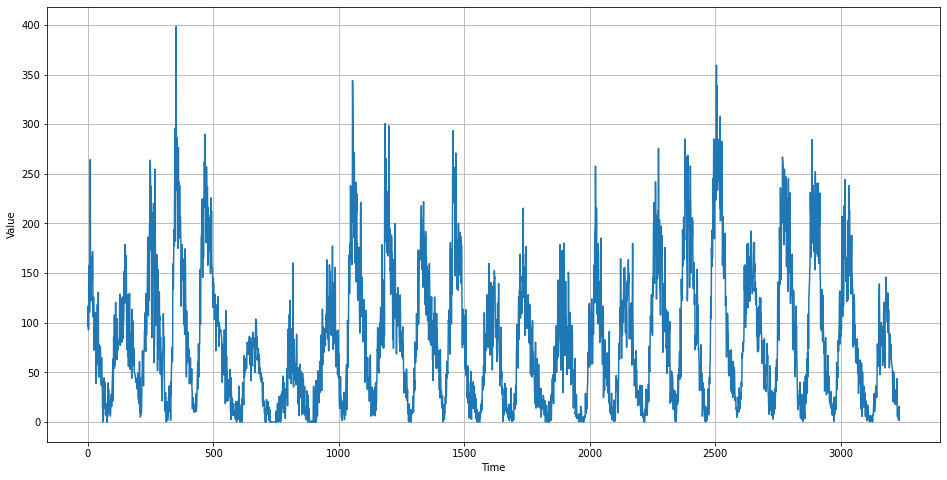

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

## Train Set, Validation Set 생성

3000 인덱스를 기준으로 Train / Validation Set를 분할 합니다.

In [63]:
split_time = 3000

In [64]:
time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[split_time:]

## Window Dataset Loader

자세한 Dataset 활용법은 [블로그 링크](https://teddylee777.github.io/tensorflow/dataset-batch-window)를 참고해 보시고, 연습해보세요!

In [65]:
# 윈도우 사이즈
window_size = 30
# 배치 사이즈
batch_size = 32
# 셔플 사이즈
shuffle_size = 1000

In [66]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

`train_set`와 `validation_set`를 만듭니다.

In [67]:
train_set = windowed_dataset(x_train, 
                            window_size=window_size, 
                            batch_size=batch_size,
                            shuffle_buffer=shuffle_size)

validation_set = windowed_dataset(x_valid, 
                                window_size=window_size,
                                batch_size=batch_size,
                                shuffle_buffer=shuffle_size)

## 모델 정의 (Sequential)

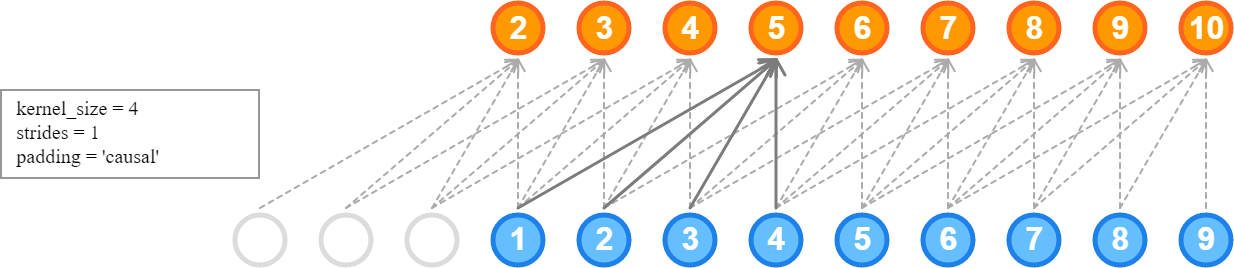

In [68]:
from IPython.display import Image

Image('https://i.stack.imgur.com/NmYZJ.png')

In [69]:
model = Sequential([
    tf.keras.layers.Conv1D(60, kernel_size=5,
                        padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),   # LSTM layer가 겹쳐있기 때문에
    tf.keras.layers.LSTM(60, return_sequences=True),   # LSTM 레이어가 마지막일 때 many_to_many : True/ many_to one : False
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)   # lambda 활용 여부는 문제의 지문에 속해 있음
])

모델의 구조 요약을 확인합니다.

In [70]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 60)          360       
                                                                 
 lstm_8 (LSTM)               (None, None, 60)          29040     
                                                                 
 lstm_9 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense_12 (Dense)            (None, None, 30)          1830      
                                                                 
 dense_13 (Dense)            (None, None, 10)          310       
                                                                 
 dense_14 (Dense)            (None, None, 1)           11        
                                                                 
 lambda_4 (Lambda)           (None, None, 1)          

## 컴파일 (compile)

**Optimizer**는 SGD(Stochastic Gradient Descent) 를 사용합니다.

* lr(learning_rate): 학습률입니다.
* momentum: 모멘텀 (가중치) 입니다.

In [71]:
optimizer = SGD(lr=1e-5, momentum=0.9)   # 1e-5: 0.00001

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


**Huber Loss**: MSE와 MAE를 절충한 후버 손실(Huber loss)

\begin{split}L_{\delta}=\left\{\begin{matrix}
\frac{1}{2}(y - \hat{y})^{2} & if \left | (y - \hat{y})  \right | < \delta\\
\delta ((y - \hat{y}) - \frac1 2 \delta) & otherwise
\end{matrix}\right.\end{split}

In [72]:
loss= Huber()

model.compile()시 우리가 튜닝한 **optimizer**와 **loss**를 활용합니다.

In [73]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["mae"])

## ModelCheckpoint: 체크포인트 생성

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [74]:
checkpoint_path = 'tmp_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_mae',   # mae 기준으로 출력하기 때문에
                             verbose=1)

## 학습 (fit)

In [75]:
epochs=100

In [76]:
history = model.fit(train_set, 
                    validation_data=(validation_set), 
                    epochs=epochs, 
                    callbacks=[checkpoint],
                   )

Epoch 1/100
     91/Unknown - 14s 10ms/step - loss: 26.6884 - mae: 27.1828
Epoch 1: val_mae improved from inf to 16.64779, saving model to tmp_checkpoint.ckpt
93/93 [==============================] - 15s 22ms/step - loss: 26.5945 - mae: 27.0890 - val_loss: 16.1551 - val_mae: 16.6478
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 20.2434 - mae: 20.7366
Epoch 2: val_mae did not improve from 16.64779
93/93 [==============================] - 1s 11ms/step - loss: 20.2434 - mae: 20.7366 - val_loss: 17.6797 - val_mae: 18.1715
Epoch 3/100
91/93 [============================>.] - ETA: 0s - loss: 20.3895 - mae: 20.8824
Epoch 3: val_mae improved from 16.64779 to 15.94071, saving model to tmp_checkpoint.ckpt
93/93 [==============================] - 1s 11ms/step - loss: 20.3963 - mae: 20.8893 - val_loss: 15.4496 - val_mae: 15.9407
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 19.0009 - mae: 19.4933
Epoch 4: val_mae did not improve from 15.94071
93/93 [==

## 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

In [77]:
model.load_weights(checkpoint_path)

## 학습 오차에 대한 시각화

In [78]:
import matplotlib.pyplot as plt

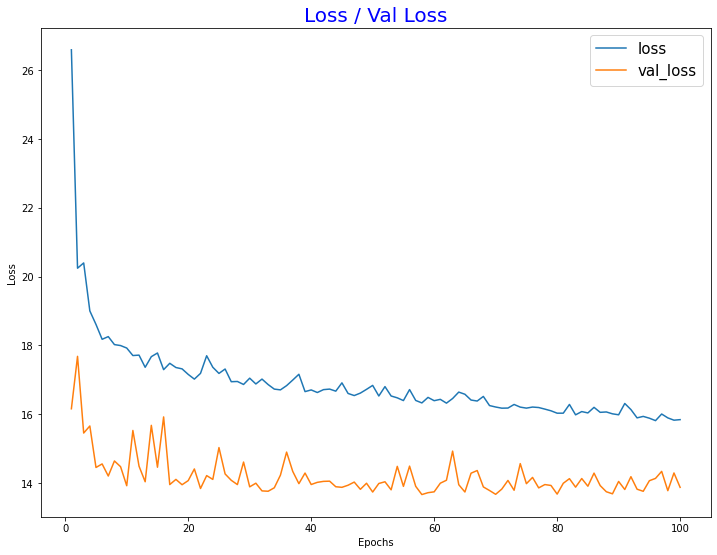

In [86]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

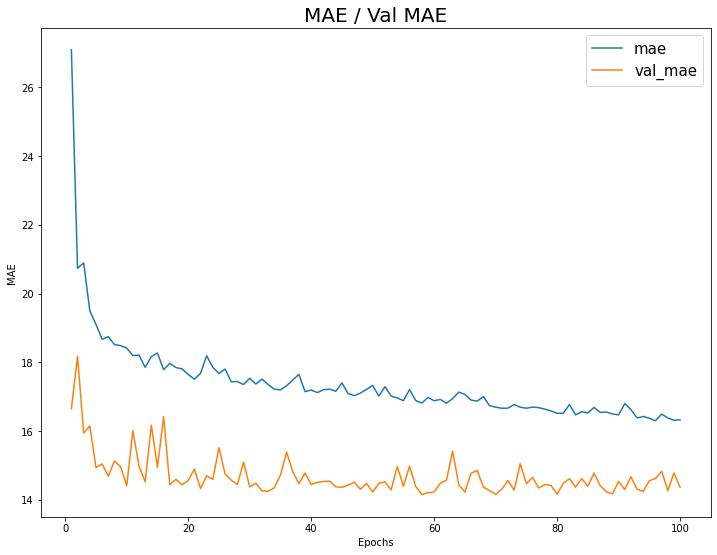

In [80]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['mae'])
plt.plot(np.arange(1, epochs+1), history.history['val_mae'])
plt.title('MAE / Val MAE', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['mae', 'val_mae'], fontsize=15)
plt.show()